In [3]:
import chess
import chess.pgn
import matplotlib.pyplot as plt
import numpy as np
import pickle  # for saving/loading Python objects

# 1) Initialize counters for piece placements
# piece_type in python-chess: 1=pawn, 2=knight, 3=bishop, 4=rook, 5=queen, 6=king
# We'll track White and Black separately.
pieceSquareCount = {
    (color, ptype): np.zeros(64, dtype=np.int64)
    for color in [chess.WHITE, chess.BLACK]
    for ptype in range(1, 7)
}

# We'll keep a tally of how many times each piece appears in total 
# across all positions (to convert counts to probabilities):
pieceTotals = {
    (color, ptype): 0
    for color in [chess.WHITE, chess.BLACK]
    for ptype in range(1, 7)
}

In [4]:
def process_position(board: chess.Board):
    """
    For a single board position, update the pieceSquareCount array
    and pieceTotals for each piece found on the board.
    """
    for square in range(64):
        piece = board.piece_at(square)
        if piece is not None:
            color = piece.color
            ptype = piece.piece_type
            pieceSquareCount[(color, ptype)][square] += 1
            pieceTotals[(color, ptype)] += 1

In [5]:
def main(pgn_file="kriegbase.unix.pgn", output_file="init_belief_state.pkl"):
    """
    Reads the PGN, accumulates piece-square counts, converts to probabilities,
    performs a sanity check, and saves the final distributions to a file.
    """
    # Open and parse every game in the PGN file
    game_count = 0
    with open(pgn_file, "r", encoding="utf-8", errors="ignore") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break  # no more games in the file
            game_count += 1
            
            board = game.board()  # starting position of the game

            # Process the initial position
            process_position(board)

            # Process positions after each move
            for move in game.mainline_moves():
                board.push(move)
                process_position(board)
    
    print(f"Processed {game_count} games from: {pgn_file}")

    # Convert raw counts to probabilities
    pieceSquareProb = {}
    for key in pieceSquareCount:
        color, ptype = key
        count_array = pieceSquareCount[key]
        total = pieceTotals[key]
        if total > 0:
            prob_array = count_array / total
        else:
            prob_array = np.zeros(64)
        pieceSquareProb[key] = prob_array

    # Save pieceSquareProb to a file so the Bayesian agent can load it later
    with open(output_file, "wb") as f:
        pickle.dump(pieceSquareProb, f)

    print(f"Saved pieceSquareProb to {output_file}")
    return pieceSquareProb

In [6]:
def make_heatmap(prob_array, title=""):
    """
    Given a length-64 array of probabilities, produce a board heatmap using matplotlib.
    """
    matrix = np.zeros((8, 8))
    for sq in range(64):
        rank = sq // 8
        file = sq % 8
        # Invert the rank to make row=0 the top
        matrix[7 - rank, file] = prob_array[sq]

    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap="hot", origin="upper")
    plt.colorbar()
    plt.title(title)

    # Label squares: x-axis a..h, y-axis 8..1
    files = ['a','b','c','d','e','f','g','h']
    ranks = ['8','7','6','5','4','3','2','1']
    plt.xticks(range(8), files)
    plt.yticks(range(8), ranks)
    plt.show()

def sample_plots(pieceSquareProb):
    """
    Example usage of make_heatmap on White Pawns and Black Queens.
    """
    # White pawns
    white_pawn_prob = pieceSquareProb.get((chess.WHITE, chess.PAWN), np.zeros(64))
    make_heatmap(white_pawn_prob, title="White Pawn Probability")

    # Black queen
    black_queen_prob = pieceSquareProb.get((chess.BLACK, chess.QUEEN), np.zeros(64))
    make_heatmap(black_queen_prob, title="Black Queen Probability")

illegal san: 'Bxe7' in r1b1kb1r/pp1pp1pp/n1p2p2/5n2/1q1PP3/B1N5/P1P2PPP/R2QKB1R w KQkq - 2 9 while parsing <Game at 0x10c012690 ('CHEssGUEVARA' vs. 'FGMA68', '2002.08.30' at 'Internet Chess Club')>
illegal san: 'Bxd2' in r1b1k1nr/p1pP2pp/8/8/1b6/8/PP1P1PPP/RNBQK1NR b KQkq - 0 8 while parsing <Game at 0x10c344230 ('avalon1175' vs. 'coughsyrup', '2002.09.30' at 'Internet Chess Club')>
illegal san: 'Ke7' in rnbq2nr/p4k1p/1p2p1p1/2BP1p2/P7/1P2PN1P/3NBPP1/R2Q1RK1 b - - 0 14 while parsing <Game at 0x10c36b620 ('Tortoise' vs. 'Fark', '2002.11.20' at 'Internet Chess Club')>
illegal san: 'Bxh3' in 1nbqkbnr/2N1ppp1/3p3p/8/8/5PPP/P1PPP2R/R1BQKBN1 b Qk - 0 8 while parsing <Game at 0x10c244d70 ('avalon1175' vs. 'Fark', '2002.11.26' at 'Internet Chess Club')>
invalid san: 'P@g4' while parsing <Game at 0x10c1ee1e0 ('Fark' vs. 'LordByron', '2002.12.08' at 'Internet Chess Club')>
invalid san: 'B@e1' while parsing <Game at 0x10c0367e0 ('Fark' vs. 'LordByron', '2002.12.08' at 'Internet Chess Club')>


Processed 16657 games from: kriegbase.unix.pgn
Saved pieceSquareProb to init_belief_state.pkl


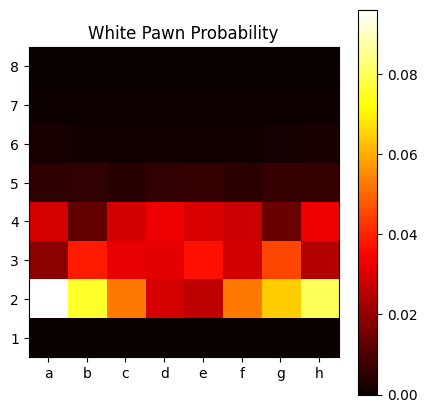

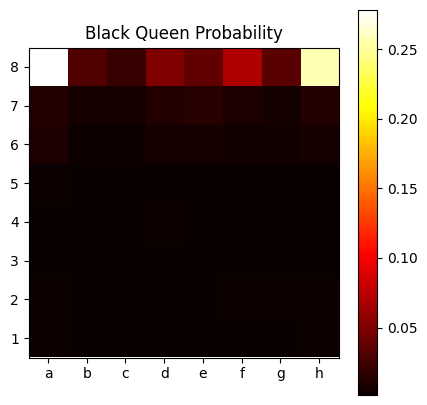

Done!


In [7]:
pgn_path = "kriegbase.unix.pgn"
output_path = "init_belief_state.pkl"

pieceSquareProb = main(pgn_file=pgn_path, output_file=output_path)

sample_plots(pieceSquareProb)

print("Done!")